# **Employee attrition modelling using XGBoost.**

# **PACE stages**


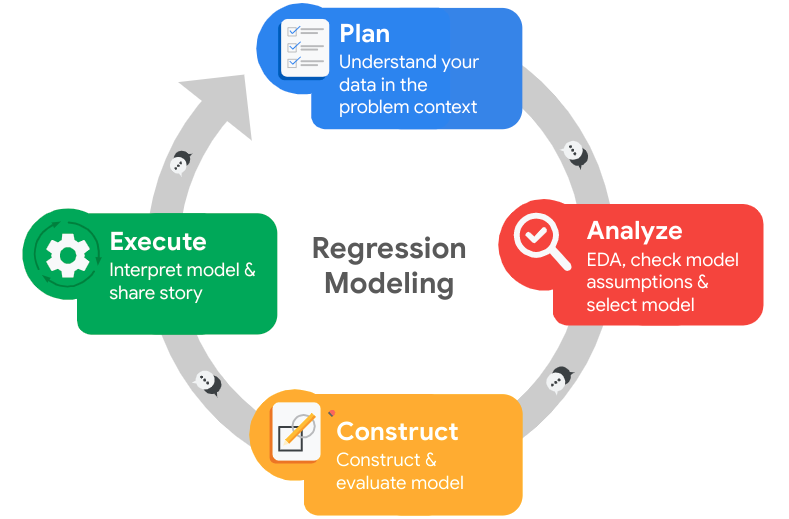

### Understand the business scenario and problem

- The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it.  
- They have the following question: what’s likely to make the employee leave the company?
- As a data analytics professional I intend to provide data-driven suggestions based on my understanding of the data.

The goals of this project are:
- to analyze the data collected by the HR department and to 
- build a model that predicts whether or not an employee will leave the company.

By predicting employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Description of the HR dataset

The dataset that you'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

# Important imports for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# Visualization package imports
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

### Load dataset

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Prevent Jupyter from hiding columns in the dataset
pd.set_option('display.max_columns', None)

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration (Initial EDA and data cleaning)

### Gather basic information about the data

In [3]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Understand the values within the `Department`
df0.Department.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: Department, dtype: int64

In [5]:
# Understand the values within the `salary`
df0.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

### Gather descriptive statistics about the data

In [6]:
# Gather descriptive statistics about the data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Rename columns

As a data cleaning step, rename the columns as needed, standardize the column names to `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [7]:
# Display column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [8]:
# Rename columns as needed
df0 = df0.rename(columns={'satisfaction_level':'satisfaction', 'last_evaluation':'last_eval', 'number_projects':'projects', 
                          'average_montly_hours':'av_monthly_hrs', 'time_spend_company':'years_at_company', 
                          'Work_accident':'work_accident',
                          'Department':'dept'})

# Display all column names after the update
df0.columns

Index(['satisfaction', 'last_eval', 'number_project', 'av_monthly_hrs',
       'years_at_company', 'work_accident', 'left', 'promotion_last_5years',
       'dept', 'salary'],
      dtype='object')

### Check missing values

In [9]:
# Check for missing values
df0.isna().sum()

satisfaction             0
last_eval                0
number_project           0
av_monthly_hrs           0
years_at_company         0
work_accident            0
left                     0
promotion_last_5years    0
dept                     0
salary                   0
dtype: int64

### Check duplicates

In [10]:
# Check for duplicates
duplicated_rows = df0[df0.duplicated(keep=False)]

# Calculating the number of duplicated rows
number_duplicated_rows = df0.duplicated().sum()
print(f'The number of duplicates in the dataset are: {number_duplicated_rows}')

The number of duplicates in the dataset are: 3008


In [11]:
# Inspect some rows containing duplicates, includes first occurence
duplicated_with_first = df0[df0.duplicated(keep=False) | df0.duplicated(keep='first')]
print(f'The total size of the duplicated rows, including first occurence is: {duplicated_with_first.shape}')

# Inspecting duplicated rows using `.sort_values()`
duplicated_rows.sort_values(['satisfaction','last_eval', 'number_project', 'av_monthly_hrs', 'years_at_company' ]).head()

The total size of the duplicated rows, including first occurence is: (5346, 10)


,satisfaction,last_eval,number_project,av_monthly_hrs,years_at_company,work_accident,left,promotion_last_5years,dept,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
71,0.09,0.77,5,275,4,0,1,0,product_mng,medium
12071,0.09,0.77,5,275,4,0,1,0,product_mng,medium


In [12]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates()
df1.shape

print('The number of rows remaining after removing the duplicates is: 11991')

# Display first few rows of new dataframe as needed
df1.head()

The number of rows remaining after removing the duplicates is: 11991


,satisfaction,last_eval,number_project,av_monthly_hrs,years_at_company,work_accident,left,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check outliers

In [13]:
# Determine the number of rows containing outliers
# Determine the interquartile range and upper limit
percentile75 = df1['years_at_company'].quantile(0.75)
percentile25 = df1['years_at_company'].quantile(0.25)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

# Create mask for outliers above above limit
mask = (df1['years_at_company'] < upper_limit)
mask_2 = (df1['years_at_company'] > upper_limit)

# Apply mask to the column
non_outliers = df1['years_at_company'][mask]
outliers = df1['years_at_company'][mask_2]

number_of_outliers = outliers.count()
print(f'The number of outliers in "years_at_company" is: {number_of_outliers}')

The number of outliers in "years_at_company" is: 824


The `years_at_company` variable contains 824 outliers. 

These outliers can be seen in the box plot below.

These values can be isolated from the dataset at a later point in case they impact the performance of the model(s) chosen.

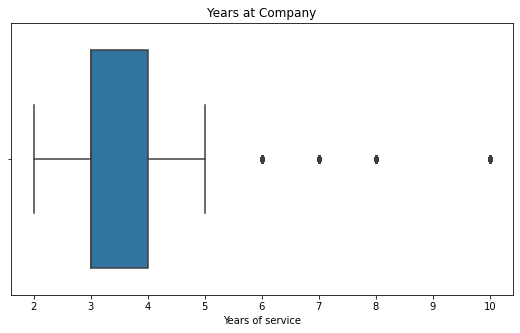

In [14]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=[9,5])
sns.boxplot(x=df1['years_at_company'])

# Label and title
plt.title('Years at Company')
plt.xlabel('Years of service')
plt.show()

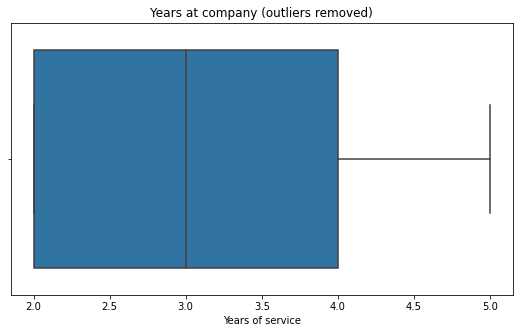

In [15]:
# Inspect the boxplot with the outliers removed, as a confirmation step
plt.figure(figsize=[9,5])
sns.boxplot(x=non_outliers)
plt.title('Years at company (outliers removed)')
plt.xlabel('Years of service');

Text(0, 0.5, 'Number of employees')

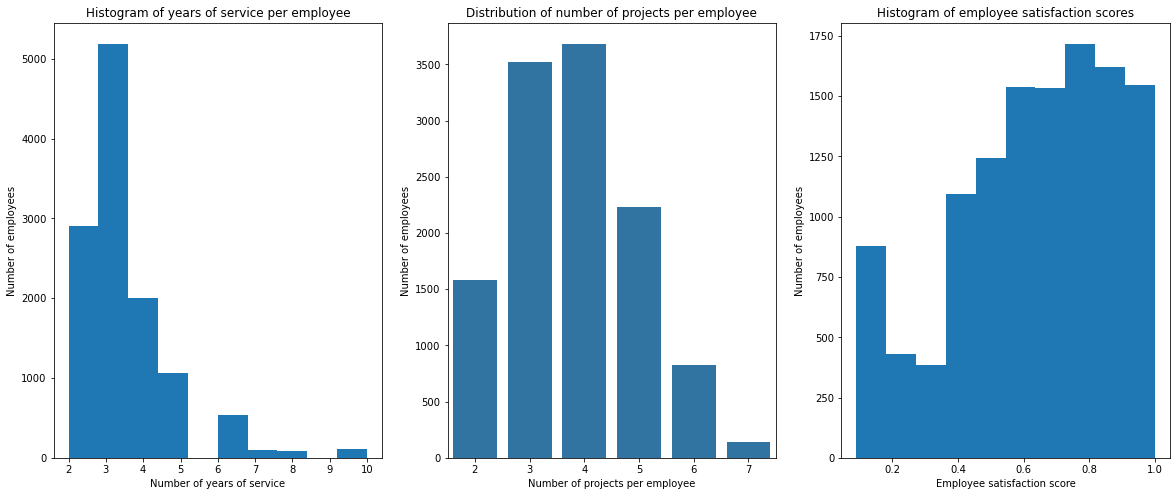

In [16]:
# Visual inspection of variables to understand distributions
# Inspection of `years_at_company` distribution
plt.figure(figsize = [20,8])
plt.subplot(1,3,1)
plt.hist(data=df1, x='years_at_company')
plt.title('Histogram of years of service per employee')
plt.xlabel('Number of years of service')
plt.ylabel('Number of employees');

# Inspection of `number_project` distribution
plt.subplot(1,3,2)
sns.countplot(data=df1, x='number_project', color='tab:blue')
plt.title('Distribution of number of projects per employee')
plt.xlabel('Number of projects per employee')
plt.ylabel('Number of employees')

# Inspection of `satisfaction`
plt.subplot(1,3,3)
plt.hist(data=df1, x='satisfaction')
plt.title('Histogram of employee satisfaction scores')
plt.xlabel('Employee satisfaction score')
plt.ylabel('Number of employees')

Text(0, 0.5, 'Number of employees')

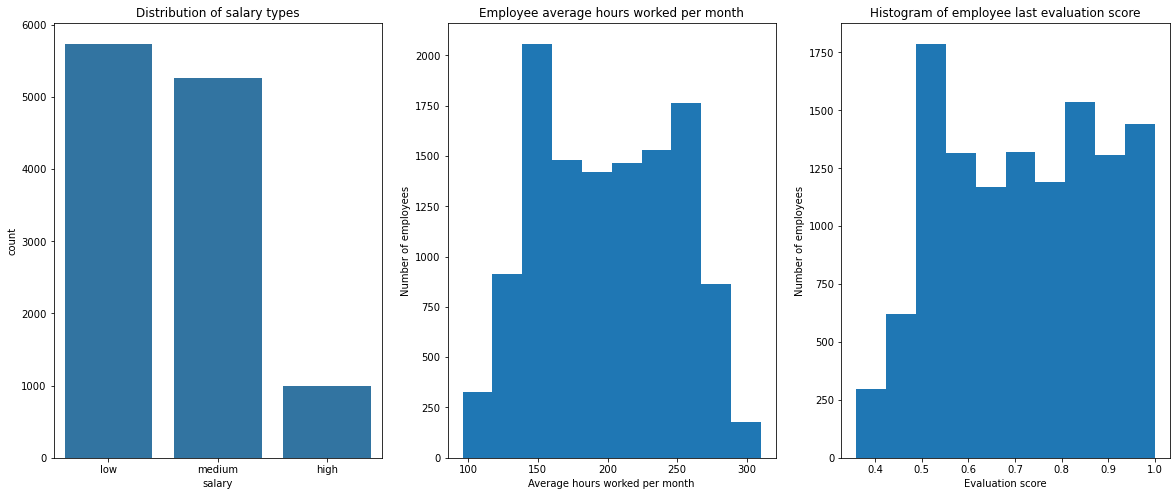

In [17]:
plt.figure(figsize = [20,8])
plt.subplot(1,3,1)
sns.countplot(x=df1['salary'], color='tab:blue')
plt.title('Distribution of salary types')

plt.subplot(1,3,2)
plt.hist(data=df1, x='av_monthly_hrs')
plt.title('Employee average hours worked per month')
plt.xlabel('Average hours worked per month')
plt.ylabel('Number of employees')

plt.subplot(1,3,3)
plt.hist(data=df1, x='last_eval')
plt.title('Histogram of employee last evaluation score')
plt.xlabel('Evaluation score')
plt.ylabel('Number of employees')

# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables)



In [18]:
# Make a copy of dataframe before transforming variables
df_mod = df1

In [19]:
# One-hot encoding of tyhe remaining categorical variable. Encoding the salary and dept variables.
df_mod = pd.get_dummies(df_mod, drop_first='True')
df_mod.head()

,satisfaction,last_eval,number_project,av_monthly_hrs,years_at_company,work_accident,left,promotion_last_5years,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


💭
### Reflect on these questions as you complete the analyze stage.
**Who are your stakeholders for this project?**

- The HR department at Salifort Motors. We are trying to predict whether an employee is likely to leave the company. The dataset consists of 15,000 observations and 10 features per employee. The dependent variable would be the `left` variable. 

**What did you observe about the relationships between variables?**

- The variables all relate to factors that could contribute to an employee leaving an organisation. These include number of projects, employee satisfaction rating, number of years with the company, salary, department, average hours worked per month. Each row of the dataset relates to a single employee.

**What do you observe about the distributions in the data?**

- The `years_at_company` data includes 824 outliers (i.e. 1.5x the IQR). The mean is 3 years and the majority have been with the company less than 4 years. When looking bthe histogram, `years_at_company` feature has a peak at 3-4 years. The next highest bin is between 2 and 3 years. Years of service above 4 is less common, tapering down to outliers at 10 years.

- The `number_of_projects` has a range of 2 up to 7. The most prevalent number of a projects is 4. This feature resembles a normal distribution.

- For the `satisfaction` score data there is a small distinct population at the lower end that have low satisfaction. From 0.4 to 1 is where the majority of employees are distributed. The peak is around 0.8.

- The `salary` data is categorical and includes 3 levels of salary. "Low" salary is the most frequent and "high" salary is the least frequent.

- The `average_monthly_hrs` spans a range of approximately 100 to 300, with the main peak at around 150 hrs and and a second peak at 270 hrs per month.


- The `evaluation` score data spans 0.4 to 1. There is a peak at 0.55. Overall, the distribution looks left skewed, therefore overall, the data is trending towards higher scores. There is a large peak at 0.6, which is at the lower end of the range. 


**What transformations did you make with your data? Why did you chose to make those decisions?**

**What are some purposes of EDA before constructing a predictive model?**
- EDA is used to get the data ready for modelling. This includes looking for outliers, duplicates and missing values.
- EDA can also include transforming data into correct datatypes, feature engineering and ensuring column names are spelled and formatted correctly. Categorical features will often need to be converted to a numerical format.

**What resources do you find yourself using as you complete this stage? (Make sure to include the links.)**
- I have found helpful to look at visualisations prior to answering these questions. Therefore pyplot and Seaborn have been helpful thus far. I have only used standard pandas code to inspect the data.

**Do you have any ethical considerations in this stage?**
- No. By having an understanding of which employees may be at risk of leaving the company, the company would be able to improve conditions and prospects for employees. Companies often invest a lot of time in training and developing personnel, therefore employee retention is high priority. 



## Step 2. Data Exploration (Continue EDA)

Get an understanding o fthe target variable, i.e. how many employees left and percentage.

In [20]:
# Get numbers of people who left vs. stayed
data = df1['left'].value_counts()
left = data.iloc[1]
stayed = data.iloc[0]
print(f'The number who have left is: {left} and the number who have stayed is: {stayed} ')

# Get percentages of people who left vs. stayed
left_pc = round((left / (left+stayed) * 100), 2)
print(f'The percentage of people that have left the company is: {left_pc}%')


The number who have left is: 1991 and the number who have stayed is: 10000 
The percentage of people that have left the company is: 16.6%


### Data visualizations

Now, examine variables that you're interested in, and create plots to visualize relationships between variables in the data.

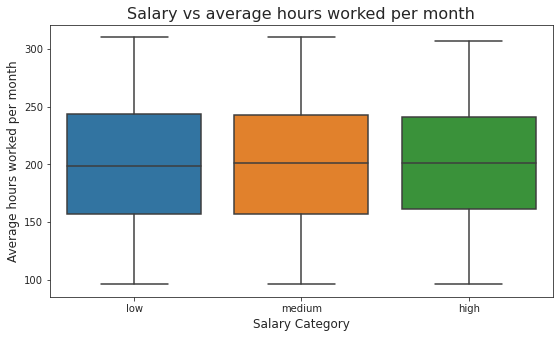

In [21]:
# Order of the salary types
order = ['low', 'medium', 'high']

# Resize plot
plt.figure(figsize=[9,5])

# Create boxplot
with sns.axes_style(style='ticks'):
    sns.boxplot(data=df1, x='salary', order=order, y='av_monthly_hrs') # Visualisation of Salary vs average hours worked

# Add title and labels
    plt.title('Salary vs average hours worked per month', fontsize=16)
    plt.xlabel("Salary Category", fontsize=12)
    plt.ylabel('Average hours worked per month', fontsize=12)

Text(0, 0.5, 'Number of projects')

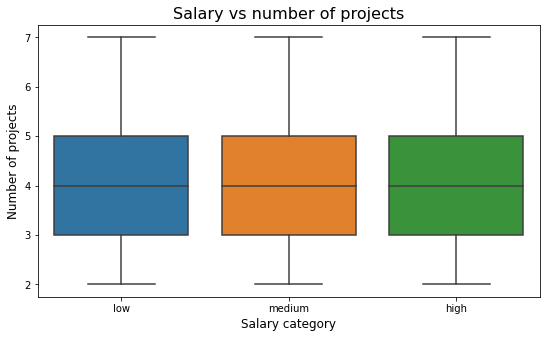

In [22]:
# Order of the salary types
order = ['low', 'medium', 'high']

# Resize plot
plt.figure(figsize=[9,5])

# Create the boxplot
sns.boxplot(data=df1, x='salary', order=order, y='number_project') # Visualisation of salary vs number of projects
#sns.set_palette("Set2")

# Add title and axes labels
plt.title('Salary vs number of projects', fontsize=16)
plt.xlabel('Salary category', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)

In [23]:
# Create a copy of the dataframe for visualisation purposes
df_vis = df1

# Relabel the `left` values to str
left_relabel = {0:'With company', 1:'Left company'}
df_vis['left_label'] = df_vis['left'].map(left_relabel)

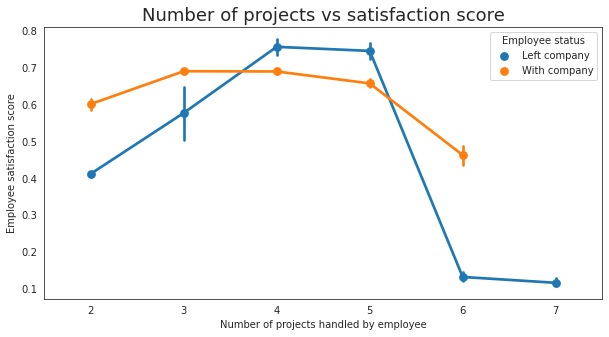

In [24]:
# Resize plot
plt.figure(figsize = [10,5])

# Create point plot
sns.set_style("white")
sns.color_palette("husl", 8)
sns.pointplot(data=df_vis, x='number_project', y='satisfaction', errorbar='sd', hue='left_label')

# Add legend, title and label axes
plt.legend(title='Employee status')
plt.xlabel('Number of projects handled by employee')
plt.ylabel('Employee satisfaction score')
plt.title('Number of projects vs satisfaction score', fontsize=18)

plt.show()

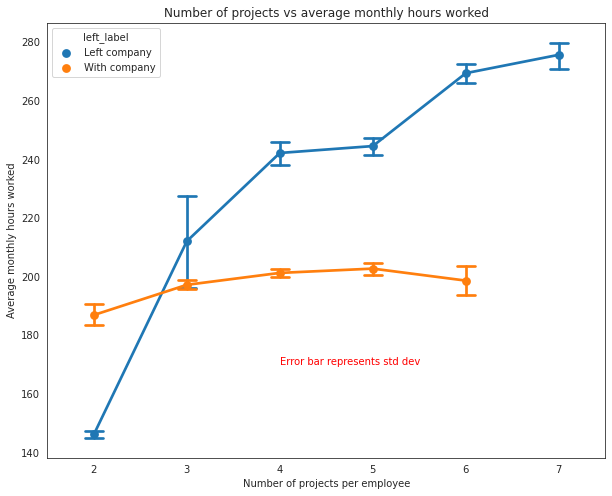

In [25]:
# Plot of number of projects vs hours worked
plt.figure(figsize=[10,8])

# Create pointplot
sns.pointplot(data=df_vis, x='number_project', y='av_monthly_hrs', errorbar='sd', capsize=0.2, hue='left_label')

# Add title and axes labels
plt.title('Number of projects vs average monthly hours worked')
plt.xlabel('Number of projects per employee')
plt.ylabel('Average monthly hours worked')

# Insert caption
plt.text(2, 170, 'Error bar represents std dev', fontsize=10, color='red')

plt.show()

The above graph of 'number of projects' vs 'satisfaction score' suggests that there is a relationship between the number of projects and the employees satisfaction. Between 3 and 5 projects is where employees seem to be most satisfied. Above 5 and below 3 projects and the staisfaction score decrease. Above 5 projects is likely to result in an employee that is over-worked, leading to stress and disatisfaction. The observations below 3 could indicate employees who are provided opportunities to be involved in enough projects to provide fulfillment and challenge. Another hypothesis could be that employees who are under-performing could taken off projects.

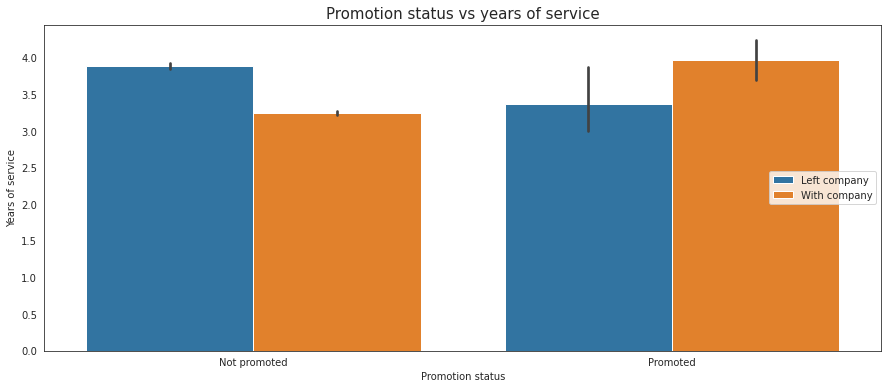

In [26]:
# Plot relationship between promotion, leaving and years served.
# Rename the promotion values
promote_label = {0:'Not promoted', 1:'Promoted'}
df_vis['promotion_label'] = df_vis['promotion_last_5years'].map(promote_label)

# Set figure size
plt.figure(figsize=[15,6])

# Create barplot
sns.set_style("white")
sns.color_palette("husl", 8)
ax = sns.barplot(data=df_vis, y='years_at_company', x= 'promotion_label', hue='left_label')

# Add legend, customised labels and title
legend = ax.legend()
legend.set_title('Employee status')   
ax.legend(loc='right')
plt.xlabel('Promotion status')
plt.ylabel('Years of service')
plt.title('Promotion status vs years of service', fontsize=15)

plt.show()

The above graph suggests that employees who are not promoted are more likely to leave than stay.
For employees who are promoted, they are more likely to stay than leave.
Promoted means promoted in the last 5 years. The mean `years_at_company` is less than 5 years for the populations described above.

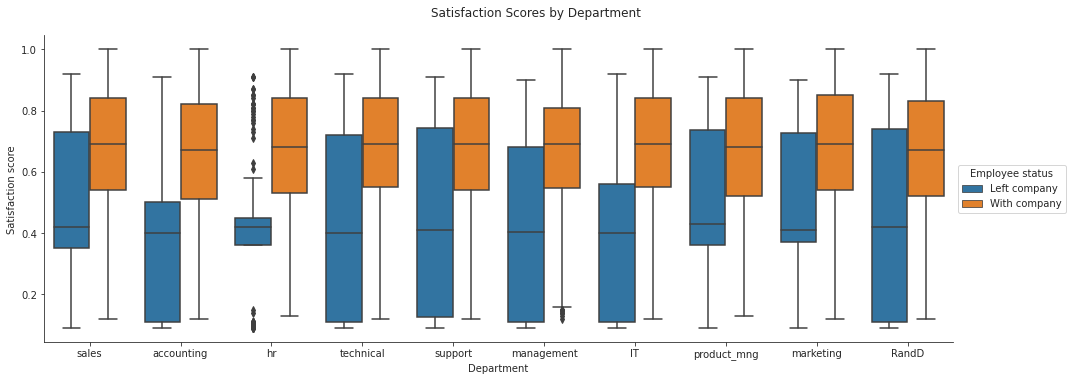

In [27]:
# Add plot title and make labels bigger

with sns.axes_style(style='ticks'):
    g = sns.catplot(x='dept', y='satisfaction', hue='left_label', data=df_vis, kind='box', aspect=3, legend=False)
    g.set_axis_labels('Department', 'Satisfaction score')
    
    # Add a title
    g.fig.suptitle('Satisfaction Scores by Department', y=1.05)
   
    plt.legend(title='Employee status', loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust position
          

g.fig.tight_layout()  # Adjust the layout to fit the title and labels
plt.show()

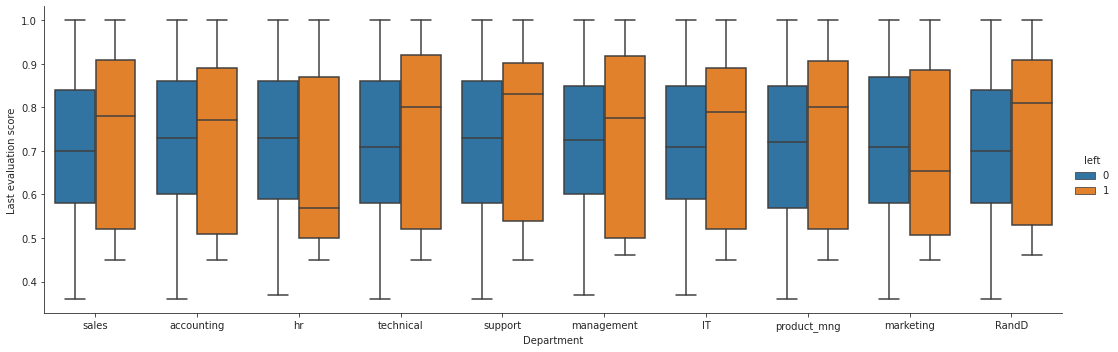

In [28]:
# Titles and labels

with sns.axes_style(style='ticks'):
    
    g = sns.catplot(x='dept', y='last_eval', hue='left', data=df1, kind='box', aspect=3)
    g.set_axis_labels('Department', 'Last evaluation score')

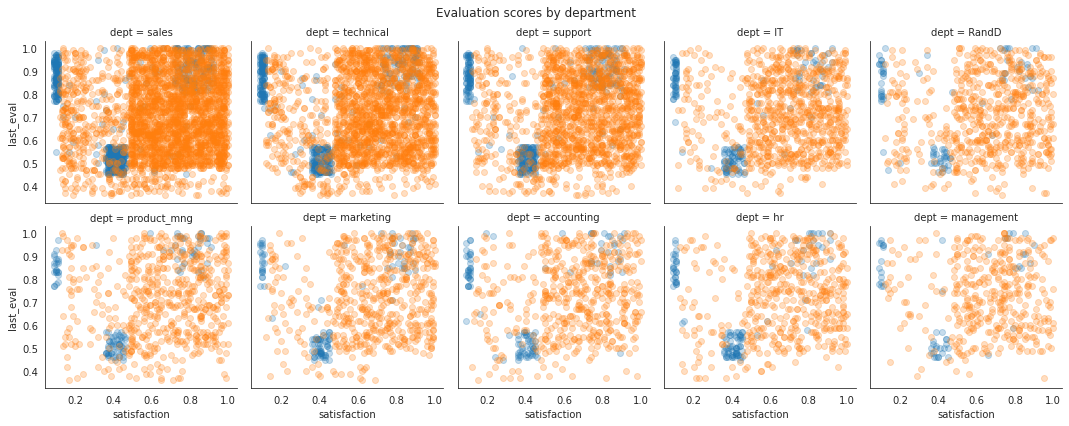

In [29]:
# Create a plot as needed
departments = df_vis['dept'].value_counts().keys()
dept_cat = pd.CategoricalDtype(categories=departments)
df_vis['dept'] = df_vis['dept'].astype(dept_cat)

g = sns.FacetGrid(data=df_vis, col='dept', col_wrap=5, hue='left_label')
g.map(plt.scatter, 'satisfaction', 'last_eval', alpha=1/4)
g.fig.suptitle('Evaluation scores by department')
g.fig.subplots_adjust(top=0.9)

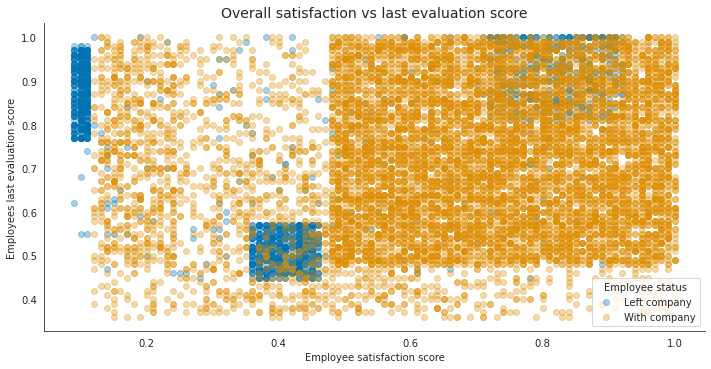

In [30]:
# Create scatterplot
g = sns.FacetGrid(data=df_vis, hue='left_label', size=5, palette='colorblind', aspect=2)
g.map(plt.scatter, 'satisfaction', 'last_eval', alpha=1/3)

# Add plot title
plt.legend(title='Employee status', loc='lower right')  
plt.title('Overall satisfaction vs last evaluation score', fontsize=14)
plt.xlabel('Employee satisfaction score', fontsize=10)
plt.ylabel('Employees last evaluation score', fontsize=10)

# Show plot
plt.show()

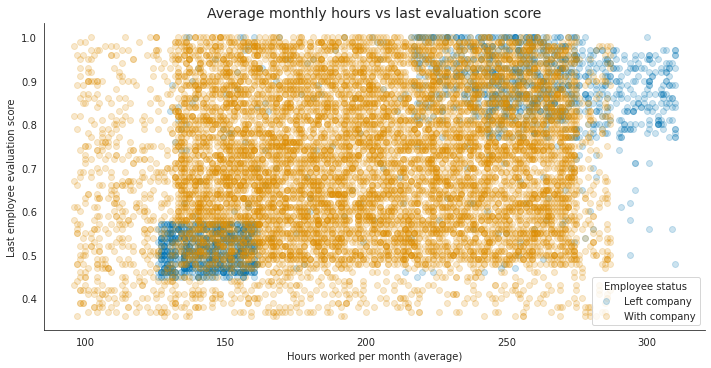

In [31]:
# Create a FacetGrid
g = sns.FacetGrid(data=df_vis, hue='left_label', size=5, palette='colorblind', aspect=2)
g.map(plt.scatter, 'av_monthly_hrs', 'last_eval', alpha=1/5)

# Add legend, title and labels
plt.legend(title='Employee status', loc='lower right')  
plt.xlabel('Hours worked per month (average)')
plt.ylabel('Last employee evaluation score')
plt.title('Average monthly hours vs last evaluation score', fontsize=14)

# Show the plot
plt.show()

The above scatter plot shows a very interesting relationship between `av_monthly_hrs`, `last_eval` and `left`. The populations within the graph are rectangular in shape. In terms of `av_monthly_hrs`, this is between 130 and 260 hrs and could relate to shifts. Further exploration of this could be performed by looking at the `dept` variable.
The `eval_score` also seems to show a delineation at around 0.5 and above. Without knowing the employee evaluation process, it's possible to assume that 0.5 is a minimum score that managers tend not to grade below. This data could be looked at more closely in a histogram with a higher number of bins than what I used above.
What is most striking in the data is the concentration of the employees that have left, shown by the two orange rectangles. Interpreting this would require talking to someone within the company about the reasons for these employees leaving, i.e. were there lay-offs or other trends within the industry that may explain the observations.

Text(0.5, 1.0, 'Pair plot of numerical variables')

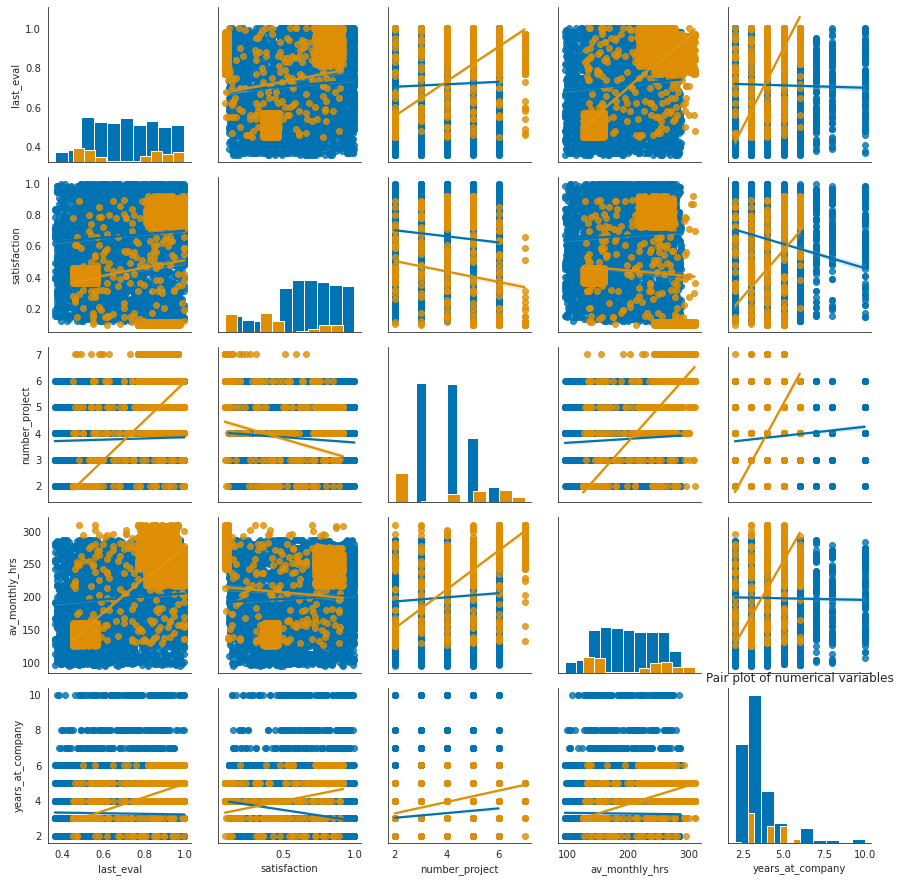

In [46]:
# Pair plot
# Need to include titles and labels

stats = ['last_eval', 'satisfaction','number_project', 'av_monthly_hrs',
       'years_at_company']

# Construct PairPlot
g = sns.PairGrid(data=df1, vars = stats, hue='left', palette='colorblind');
g.map_offdiag(sns.regplot)
g.map_diag(plt.hist);

plt.title('Pair plot of numerical variables')

plt.show()

### Insights

The dataset has a number of interesting trends that are complex and there does not appear to be a simple linear relationship between the input variables and the dependent variable. 

For this reason, a decision tree or xgboost model is more likely to provide a better model.

XGBoost modeling is known to be a good choice when it comes to employee attrition modeling. One of the downsides is that it can be difficult to interpret.

Compared to more traditional statistical models, XGBoost is highly flexible with fewer strict assumptions. It can capture complex, non-linear relationships through its decision trees.

# paCe: Construct Stage

- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


## Recall model assumptions

**Key Assumptions for XGBoost:**

**No Assumption of Linear Relationships:**
XGBoost does not assume a linear relationship between features and the target variable.

**Handling of Missing Data:**
XGBoost can handle missing data, there is no strict assumption that your dataset must be complete.

**Feature Independence:**
Like other tree-based methods, XGBoost does not assume feature independence. However, if features are highly correlated, it might affect interpretability.

**No Assumption of Homoscedasticity:**
XGBoost does not assume that the variance of the residuals is constant (homoscedasticity). It can handle heteroscedasticity effectively.

**Feature Scaling Not Required:**
XGBoost does not require features to be standardized or normalized.

**No Assumption of Normally Distributed Errors:**
XGBoost does not assume that the errors (residuals) are normally distributed.

**Outliers and Non-linearity:**
XGBoost is relatively robust to outliers and can capture non-linear patterns.


**Sufficient Data:**
XGBoost requires a sufficient amount of data to perform well. Overfitting can be an issue if the model is too complex relative to the amount of data available.

**Balanced Classes (for Classification):**
XGBoost performs better when the classes in classification tasks are somewhat balanced. Therefore stratified sampling will be used.

**Additional Considerations:**

**Hyperparameter Tuning:**
XGBoost has several hyperparameters that need to be tuned carefully. Default settings may not work optimally for all datasets.

**Feature Engineering:**
While XGBoost can handle raw data, feature engineering can significantly improve performance.

**Regularization:**
XGBoost includes regularization terms to prevent overfitting.

## Step 3. Model Building, Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

This is a binary classification prediction task to determine if an employer is likely to leave a company based on a number of predictor variables.

### Identify the types of models most appropriate for this task.

XGBoost modeling is very well-suited to this type of application.

### Modeling

In [33]:
# Define the y (target) variable
y = df_mod['left']

# Define the X (predictor)variables
X = df_mod.drop(columns='left', axis=1)

In [34]:
# Perform split operation on dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify=y)

In [35]:
# Instantiate classifier
xgb=XGBClassifier(objective='binary:logistic', random_state=0)

# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



In [36]:
# Setting hyperparameters
cv_params = {'max_depth': [4,6],
            'min_child_weight': [0.7],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [5,10,15],
            'subsample': [0.7],
            'colsample_bytree': [0.7]}

In [37]:
# Setting the evaluation metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [38]:


xgb_cv = GridSearchCV(xgb,
                     cv_params,
                     scoring=scoring,
                     cv=5,
                     refit='f1')

In [39]:
# Train the model
# xgb_cv = xgb_cv.fit(X_train, y_train)
# xgb_cv

In [40]:
# Write and read results of xgb_cv model

# Set filepath
path = '/home/jovyan/work/capstone_pd.pkl'

# with open (path, 'wb') as to_write:
#   pkl.dump(xgb_cv, to_write)
    
with open(path, 'rb') as to_read:
    loaded_data = pkl.load(to_read)

In [41]:
# Rename the loaded data to `xgb_1`, this is the same as `xgb_cv` above
xgb_1 = loaded_data

# Show the best parameters
xgb_1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 0.7,
 'n_estimators': 15,
 'subsample': 0.7}

In [42]:
# Test the model using the test data
y_pred = xgb_1.predict(X_test)

In [43]:
# Print the performance scores
# Print accuracy score
ac_score = accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# Print precision score
pc_score = precision_score(y_test, y_pred)
print('precision score:', pc_score)

# Print your recall score.
rc_score = recall_score(y_test, y_pred)
print('recall score:', rc_score)

# Print your f1 score.
f1_score = f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9829886591060707
precision score: 0.9869281045751634
recall score: 0.9096385542168675
f1 score: 0.9467084639498433


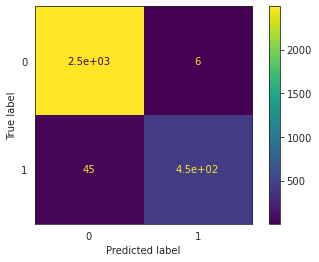

In [44]:
# Construct and display confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create the display for your confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_1.classes_)

# Plot the visual in-line.
disp.plot()

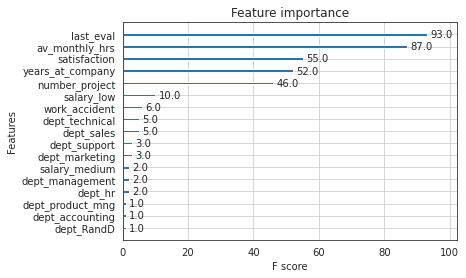

In [45]:
plot_importance(xgb_1.best_estimator_)

## Step 4. Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




### Summary of model results

**Accuracy Score: 0.983**
This means that 98.3% of the total predictions made by the model are correct.
A high accuracy score like this is generally very good, but it's important to ensure that the dataset is balanced. In case of class imbalance, accuracy might not be the best metric, and other metrics like precision, recall, and F1 score become more informative.

**Precision Score: 0.987**
Precision is the ratio of correctly predicted positive observations to the total predicted positives (TP / (TP + FP)). A precision score of 0.987 means that 98.7% of the instances predicted as positive are actually positive.
This is an excellent precision score. It indicates that your model is very good at minimizing false positives (i.e., it rarely predicts a positive class when it isn't).

**Recall Score: 0.910**
Recall is the ratio of correctly predicted positive observations to all actual positives (TP / (TP + FN)). A recall score of 0.910 means that 91.0% of the actual positive instances are correctly identified by the model.
While this is still a strong recall score, it's slightly lower than the precision score. This could indicate that the model is slightly conservative in predicting positives, possibly missing some (false negatives). Depending on your use case, a recall of 91% could be considered good or might need improvement, especially if false negatives are costly.

**F1 Score: 0.947**
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A score of 0.947 means your model has a good balance between precision and recall.
A high F1 score like this is generally a strong indicator of overall performance, especially when both precision and recall are important.

**Overall Assessment:**
Strengths: The model has excellent precision and accuracy, which indicates that it's making very few errors overall and very few false positives in particular.
The recall score is slightly lower compared to precision. If the application prioritised capturing as many positives as possible (e.g., in medical diagnosis or fraud detection where missing a positive instance is costly), it might be worth working on improving recall. However, in this case, a recall of 91% is still very good.

### Conclusion, Recommendations, Next Steps
**What key insights emerged from your model(s)?**
The Evaluation score, average hours worked per month, satisfaction, years at company and number of projects are the biggest indicators of employee attrition. Each of these factors needs to be analysed more closely to see how they contribute to an employee leaving a company.

**What business recommendations do you propose based on the models built?**
Firstly, the modeling has performed very well, as outlined in the summary below.
Further investigation is required to understand what aspects of each of these features are contributing to attrition.

**What potential recommendations would you make to your manager/company?**
One of the limitations of XGBoost is that the results can be difficult to interpret. It would be worth using a decision tree model to go back and undertsand how each of the features contributes and in what combinations.

**Given what you know about the data and the models you were using, what other questions could you address for the team?**
An Executive summary of the findings will be delivered and findings can be presented in more detail to the HR team to explain the methodology and what (if any) further investigations might be required.

**Which independent variables did you choose for the model and why?**
All of the independent variables were used in this model. By using the XGBoost model collinearity issues are often avoided. Based on the results of the modeling  it has preformed very well and has not been negatively impacted by colinearity.

**Are each of the assumptions met?**
As outlined above, there are very few assumptions that need to be met with XGBoost.

**How well does your model fit the data?**
The model fits the data very well.
The accuracy and precision scores are over 98%
    accuracy score: 0.983
    precision score: 0.987
    recall score: 0.910
    f1 score: 0.947

**Can you improve it? Is there anything you would change about the model?**
The model is already very accurate. Given that the purpose of the modeling is to determine what are the key areas that the company can focus to reduce attrition, then the model is able to do this. This can be seen by the feature importance graph. These features are unlikely to change with further tuning of the model.

**What resources do you find yourself using as you complete this stage?**
I have used the notes from the course and web searches to fill in any gaps in knowledge along the way.

**Do you have any ethical considerations in this stage?**
There are ethical considerations for this type of modelling. Although the model identifies the important features that indicate attrition, it may not always be in the employees best interest to stay with a company. A company should be careful not to engage in activites that would it difficult for an employee to leave a company or make it difficult for them to progress and develop, that could lead to them being poached by another company.This is a very big topic and beyond the scope of this particular notebook.



**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.